Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before **14:00 of Tuesday, December 7, 2021**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

YOUR ANSWER HERE

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Gradients
What is the gradient of a pixel? How do we calculate the first, how the second derivative of an image?  

Gradient of a pixel is when the intensity or the color change its magnitude. We compute a gradient on an image by putting a threshold on the gradient magnitude, so we can find the intensity of the gradient and by that we can label the edges and the regions of an image. In order to accomplish that we apply specific algorithms, such as edge linking, canny operator, detection of zero crossings and watershed transform. 

### b) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

The idea is to search a pixel which was not unprocessed and merge it with other pixels so they form an edge. By following  the gradient direction we can guess the edge continuity and at the end we obtain the edge of the object.

### c) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

Zero crossings of second derivative are contours of connected segments, and it leads to clsoed contours because the Laplace operator used is noise sensitive, so these ony correspond to real edges if the second derivative values are close to zero.

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

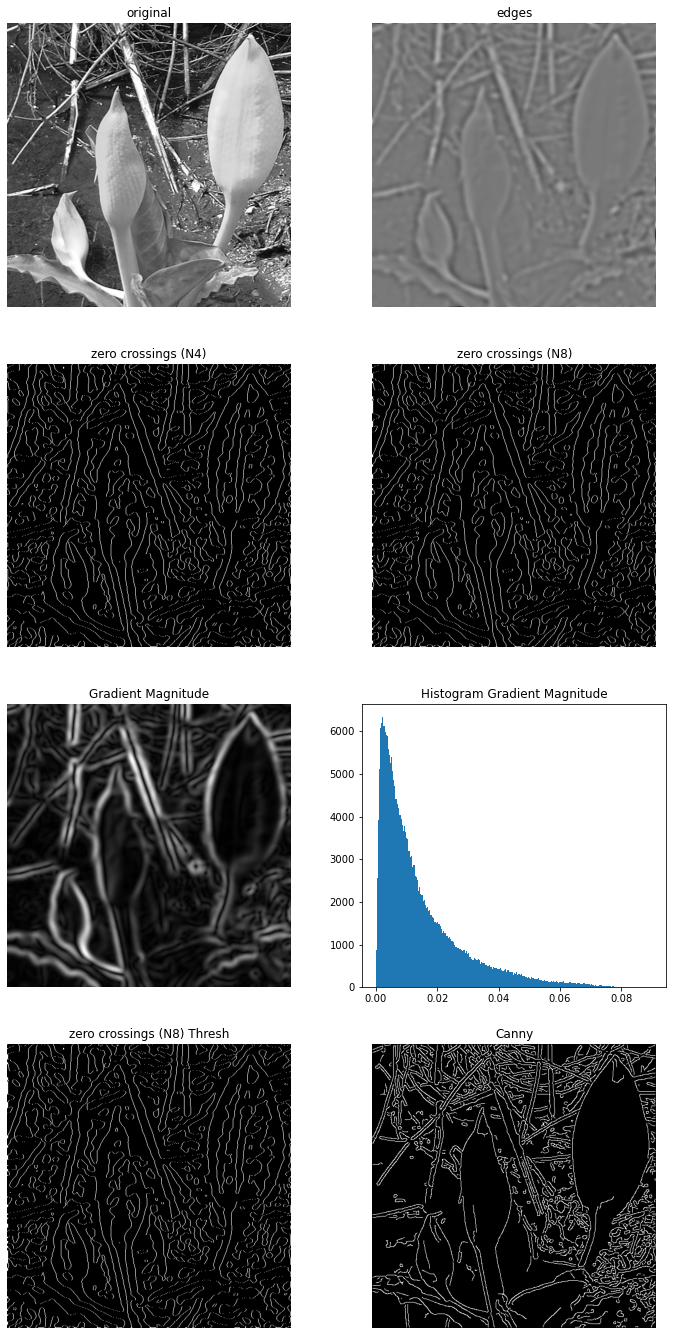

In [12]:
from skimage import filters
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.filters import gaussian, laplace, sobel, threshold_otsu
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def zero_crossing_4(img):
    zero_crossing_n4 = np.zeros(img.shape)
    M, N = img.shape
    # Shift
    for i in range(M-1):
        for j in range(N-1):
            zero_crossing_n4[i+1][j] = img[i][j]
            zero_crossing_n4[i][j+1] = img[i][j]
    return (img * zero_crossing_n4 <= 0)

def zero_crossing_8(img):
    zero_crossing_n8 = np.zeros(img.shape)
    M, N = img.shape
    for i in range(M-1):
        for j in range(N-1):
            zero_crossing_n8[i+1][j] = img[i][j]
            zero_crossing_n8[i][j+1] = img[i][j]
            zero_crossing_n8[i+1][j-1] = img[i][j]
            zero_crossing_n8[i+1][j+1] = img[i][j]
    return (img * zero_crossing_n8 <= 0)

img = imread('images/swampflower.png').astype(float)
# img = imread('images/peppers.png').astype(float)

if len(img.shape)>2:
    img = rgb2gray(img)
img /= img.max()

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood

# 1. Smoothing with gaussian
smoothed_img = gaussian(img, sigma=5)

# 2. Compute gk with Laplacian operator
edges = laplace(smoothed_img)

# 3. Find zero crossings by shifting gk
zero_crossings_n4 = zero_crossing_4(edges)
zero_crossings_n8 = zero_crossing_8(edges)

grad_mag = sobel(smoothed_img)
grad_mag_threshold = threshold_otsu(grad_mag)

zero_crossings_n8_threshold = zero_crossings_n8.copy()
zero_crossings_n8_threshold[grad_mag < grad_mag_threshold] = 0

plt.figure(figsize=(12, 24))
plt.gray()

plt.subplot(4,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(4,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(4,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(4,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )
plt.subplot(4,2,5); plt.axis('off'); plt.imshow(grad_mag); plt.title('Gradient Magnitude' )
plt.subplot(4,2,6); plt.hist(grad_mag.flatten(), 255, (0, grad_mag.max())); plt.title('Histogram Gradient Magnitude' )
plt.subplot(4,2,7); plt.axis('off'); plt.imshow(zero_crossings_n8_thresh); plt.title('zero crossings (N8) Thresh' )
plt.subplot(4,2,8); plt.axis('off'); plt.imshow(canny(img,sigma=2)); plt.title('Canny')
plt.show()

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



The watershed transform algorithm much like its name, it treats the result as a work of actual watershed - the water flows downhill until it reaches the lowest point. That lowest point in regards to the algorithm is what would be the strongest egdge. The two approaches discussed in the lecture are 'Rain' and 'Flood'.
The 'Rain' algorithmic method, just like a rain, falls on all the pixels in the grayscale image and the water gathers at the lowest point, gradient zero. 
The 'Flood' occurs when the the water is continously rising and 'flooding' the relief. In this method, the watershed is detected when the 'water' of different valleys meet (as shown in the lecture).
As like in zero crossings, the watershed transform always gives a closed contour and this is due to the water meeting point being zero and the output is generated identifying these points. 

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildin functions for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

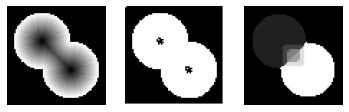

In [7]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage.segmentation import watershed as ws
%matplotlib inline

def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """

    NO_LABEL = 0
    WATERSHED = 1
    NEW_LABEL = 2

    # initialize labels
    label = np.zeros(img.shape, np.uint16)
    
    # initialize shape
    M, N = img.shape
    
    # initialize loop variables
    maximum = img.max()
    h = 0
    
    while h < maximum:
        for i in range(M - 1):
            for j in range(N - 1):
                if h >= img[i][j] and label[i][j] == NO_LABEL:
                    img_neighbors = [
                            img[i - 1][j - 1], img[i][j - 1], img[i + 1][j - 1], 
                            img[i - 1][j],                    img[i + 1][j], 
                            img[i - 1][j + 1], img[i][j + 1], img[i + 1][j + 1]
                        ]
                    label_neighbors = [
                            label[i - 1][j - 1], label[i][j - 1], label[i + 1][j - 1], 
                            label[i - 1][j],                      label[i + 1][j], 
                            label[i - 1][j + 1], label[i][j + 1], label[i + 1][j + 1]
                        ]


                    # isolated
                    if all(h > neighbor for neighbor in label_neighbors):
                        label[i][j] = NEW_LABEL
                    # segment
                    elif all(label_neighbors[0] == neighbor for neighbor in label_neighbors):
                        label[i][j] = label_neighbors[0]
                    # watershed
                    else:
                        label[i][j] = WATERSHED

        h += 1
    
    for i in range(M):
        for j in range(N):
            label[i][j] = 0 if label[i][j] == WATERSHED else 1
            
    return label

img = imageio.imread('images/dist_circles.png', pilmode='L')

plt.gray()
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img);
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(watershed(img))
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(ws(img))
plt.show()

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.
You can use build-in functions instead of your own watershed function.

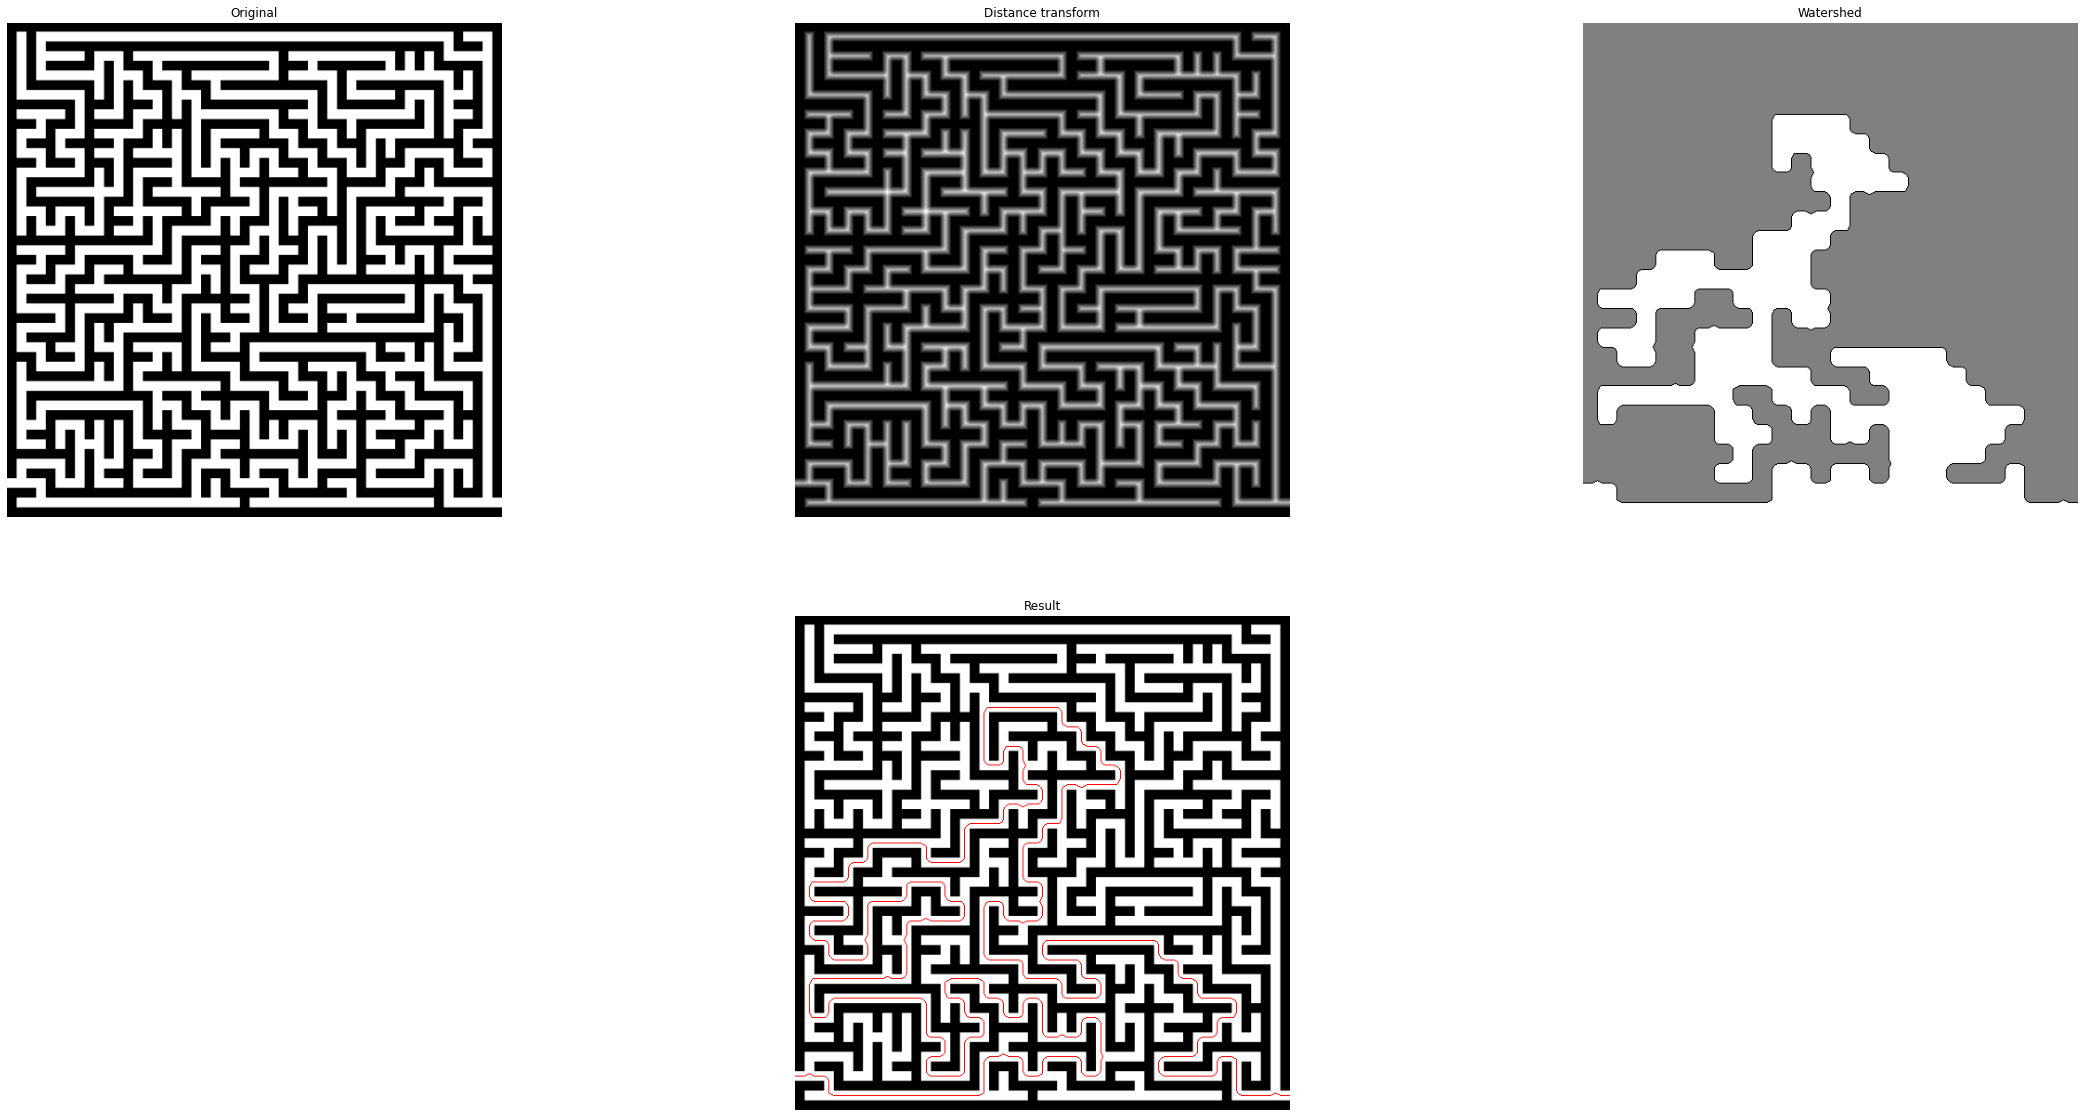

In [57]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import watershed as ws

%matplotlib inline

img = imageio.imread('images/maze1.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'

result = img[:, :, np.newaxis].repeat(3, 2)
distance = distance_transform_edt(img)
water = ws(img, watershed_line=True)

result[water == 0] = (255, 0, 0)

plt.figure(figsize=(40, 20))
plt.gray()
plt.subplot(2,3,1); plt.axis('off'); plt.imshow(img); plt.title('Original')
plt.subplot(2,3,2); plt.axis('off'); plt.imshow(distance); plt.title('Distance transform')
plt.subplot(2,3,3); plt.axis('off'); plt.imshow(water); plt.title('Watershed')
plt.subplot(2,3,5); plt.axis('off'); plt.imshow(result); plt.title('Result')

plt.show()

YOUR ANSWER HERE

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

K-means clustering is an algorithm that identifies groups in a data set, that have not been specifically labelled. 
N observations are partitioned into K clusters by repeatedly, randomly selecting a centroid. Then, the data points are assigned to a cluster so that the sum of the squared distance between the data points/observations and centroid are minimal. 
K-means clustering is often utilised in computer vision to segment an area of interest from the background of an image.

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.cdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

<IPython.core.display.Javascript object>


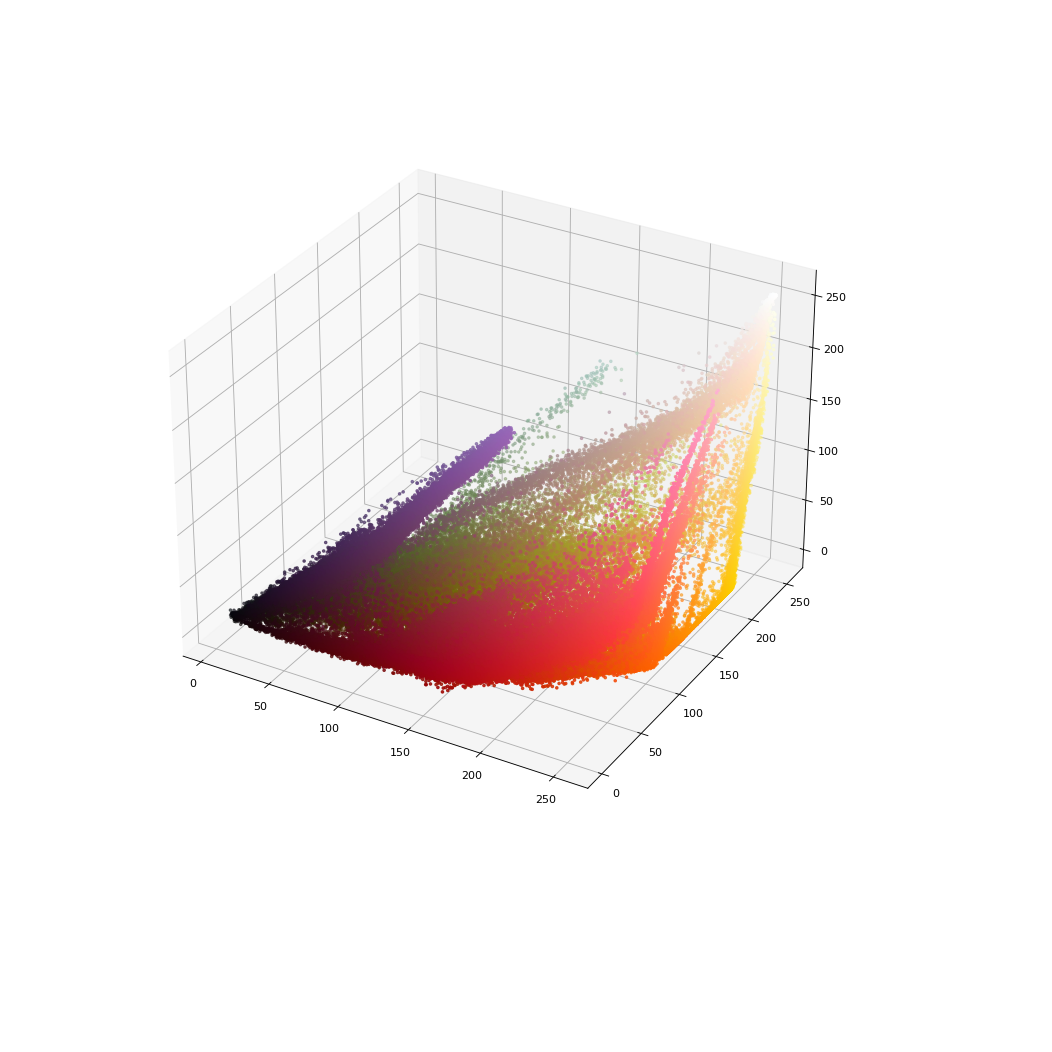

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib notebook

img = imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

In [5]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from imageio import imread
import time
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_rgb(img, k, threshold=0, do_display=None):
    """
    k-means clustering in RGB space.

    Args:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): 'number of clusters' x 3 array. 
            RGB color for each cluster center.
    """
    t = 0
    
    vec = img.reshape((-1, img.shape[2]))
    n_pixels = vec.shape[0]
    
    random_indices = np.random.choice(n_pixels, size=k, replace-False)
    centers = vec[random_indices]
    
    change = float('Inf')
    
    while change > threshold:
        old_centers = centers.copy()
        
        cluster = distance.cdist(vec, centers).argmin(axis=1)
        
        for i in range(k):
            if i in cluster_for_each_rgb:
                # determine colors that are assigned to the currently considered cluster
                colors = [rgb_list[x] for x in range(len(rgb_list)) if cluster_for_each_rgb[x] == i]

                # update cluster center
                new_center = []
                for channel in range(3):
                    avg = 0
                    for x in colors:
                        avg += x[channel]
                    new_center.append(int(avg / len(colors)))

            else:
                # re-initialize center
                new_center = np.random.randint(255, size=3)
            
            change += distance.cdist([centers[i]], [new_center])
            centers[i] = new_center

img = imread('images/peppers.png')

cluster, centers = kmeans_rgb(img, k=7, threshold=0, do_display=True)
plt.imshow(centers[cluster])
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-5-9ccb953f6f7e>, line 31)

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color
from imageio import imread
%matplotlib inline
# from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

img = imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0):
    """
    k-means clustering in HSV space.

    Args:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    # YOUR CODE HERE
    return cluster, centers


img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv = kmeans_hsv(img_hsv[:,:,:], k, theta)
if (centers_hsv.shape[1] == 3):
    plt.imshow(color.hsv2rgb(centers_hsv[cluster]))
else:
    plt.gray()
    plt.imshow(np.squeeze(centers_hsv[cluster]))
plt.show()

## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).

In a recursive implementation the floodfill function is called for the seed pixel. In the function a recursive call for the four neighbouring pixels is made, if the color of the pixel, the function is called with, is similar to the seed color. If this is the case the pixel is added to the region. [Other](https://en.wikipedia.org/wiki/Flood_fill) more elegant solutions exist aswell.

The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


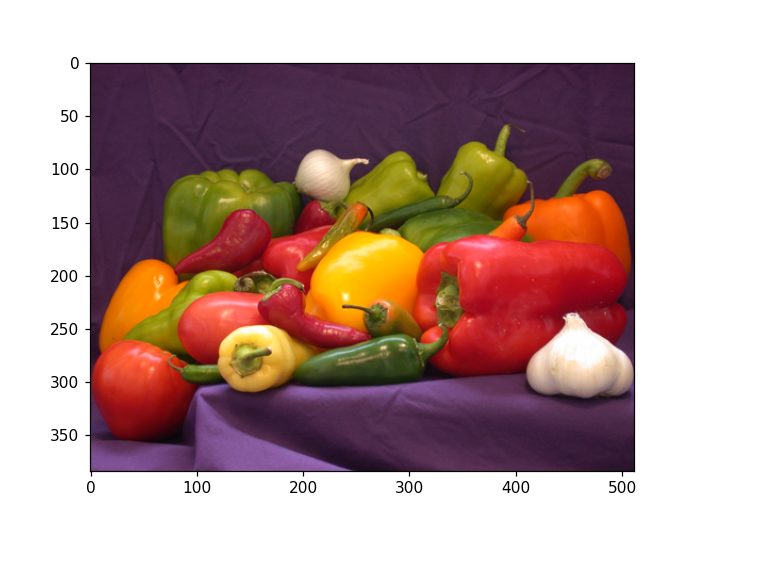

In [3]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy.ndimage as ndimage
from sys import setrecursionlimit
from scipy.spatial import distance

threshold = .08;

setrecursionlimit(100000)

def floodfill(img, mask, x, y, color, region):
    """Recursively grows region around seed point
    
    Args: 
        img (ndarray): The image in which the region is grown
        mask (boolean ndarray): Visited pixels which belong to the region.
        x (uint): X coordinate of the pixel. Checks if this pixels belongs to the region
        y (uint): Y coordinate of the pixel.
        color (list): The color at the seed position
    """
    if distance.cdist([img[x][y]], [color]) < threshold:
        mask[x,y] = True
        neighbours = [(x - 1, y - 1), (x, y - 1), (x + 1, y - 1), 
                      (x - 1, y),                 (x + 1, y), 
                      (x - 1, y + 1), (x, y + 1), (x + 1, y + 1)]
        for x, y in neighbours:
            if not mask[x][y]:
                mask = floodfill(img, mask, x, y, color)
    return mask

def on_press(event):
    """Mouse button press event handler
    
    Args:
        event: The mouse event
    """
    y = math.floor(event.xdata)
    x = math.floor(event.ydata)
    color = img_filtered[x, y, :]

    init_mask = np.zeros((img.shape[0], img.shape[1]))
    mask = floodfill(img_filtered, init_mask, x, y, color)
    
    plt.imshow(img)
    fig.canvas.draw()
    

def fill_from_pixel(img, img_filtered, x,y):
    """ Calls floodfill from a pixel position
    
    Args:
        img (ndarray): IO image on which fill is drawn.
        img_filtered (ndarray): Processing image on which floodfill is computed.
        x (uint): Coordinates of pixel position.
        y (uint): Coordinates of pixel position.

    Returns:
        img (ndarray): Image with grown area in white
    """
    mask = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    region = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    color = img_filtered[x,y, :]
    floodfill(img_filtered, mask, x, y, color, region)
    img[region] = (255,255,255)
    
    return img


img = imageio.imread('images/peppers.png')
img_hsv = color.rgb2hsv(img)
img_filtered = ndimage.median_filter(img_hsv, 5)
# img = fill_from_pixel(img, img_filtered, 200, 300) # Comment in to deactivate simple testing at fixed position
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)

fig.canvas.mpl_connect('button_press_event', on_press)

plt.show()